In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

def generate_graph_linewidth(num_Vs):
    # Just a heuristic
    return np.max([0.5, -0.086 * np.sqrt(num_Vs) + 7.66])

In [2]:
file = open("tiling/square_periodic/eigenvalue_data.pkl", "rb")
eigenvalue_data = pickle.load(file)
file.close()

In [4]:
def calculate_pde_eigenvalues(m, n):
    a = 1 / 2# * ((1 + np.sqrt(2))**2 / 6)
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [5]:
calculate_pde_eigenvalues(0, 1)

4.442882938158366

In [14]:
eigenvalue_data[2500][1]

4.441420278112985

In [ ]:
4.4414202781129831581

In [ ]:
g = construct_graph.tiling.Tiling(tile_type='rectangular_tile', periodic=True,
                                    num_horizontal_displacements=50,
                                    num_vertical_displacements=25,
                                    autoplot=False, figsize=5)

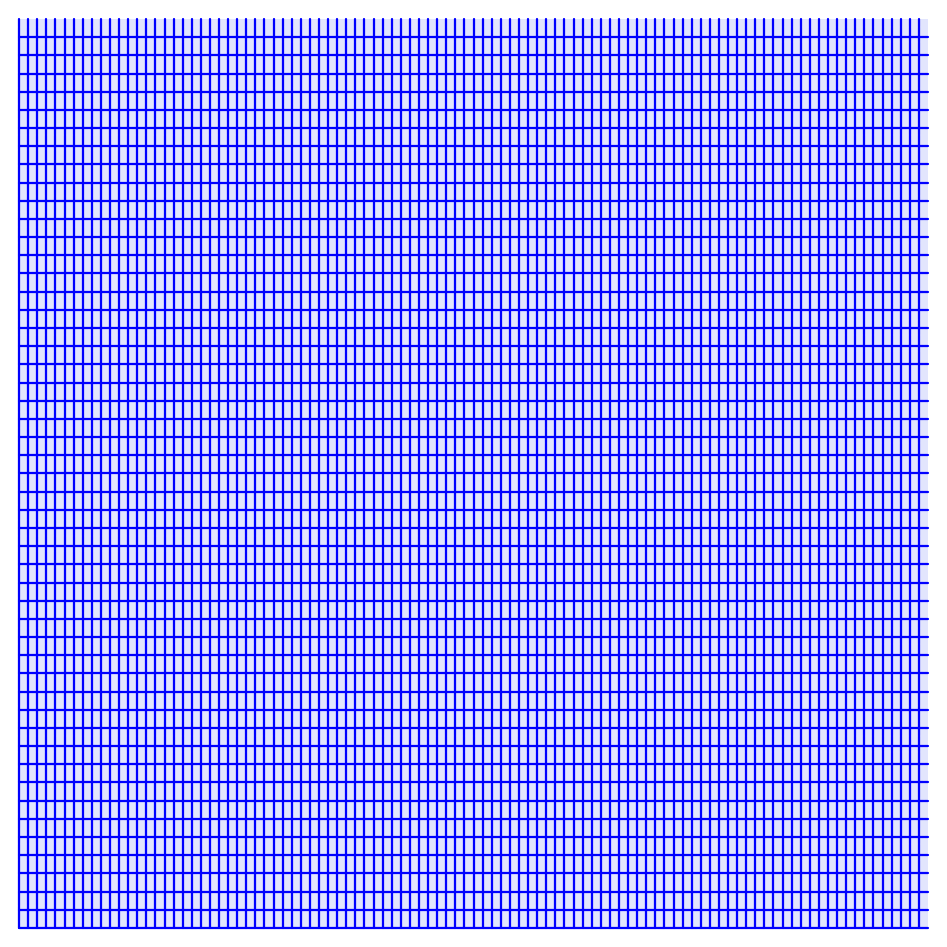

In [12]:
fig, ax = g.plot_graph(return_figax=True, 
                       capstyle="round", linewidth=generate_graph_linewidth(g.num_Vs),
                       background_color="white", embedding_space="square")
plt.savefig("tiling/rectangular_periodic/large_rectangular_tiling.png", dpi=200, bbox_inches="tight")
# ax.axis('on')
# for en, v in enumerate(g.V_coords):
#     ax.annotate(str(en), v)

In [7]:
def calculate_pde_eigenvalues(m, n):
    a = 1 / 2# * ((1 + np.sqrt(2))**2 / 6)
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

def style_plot(fig, ax, aspect="equal", no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect:
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(20)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')
    
class Graph_Function:

    def __init__(self, data, domain=None):

        self.data = data
        self.domain = domain

    def __add__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        result = [i + j for i, j in zip(self.data, other.data)]

        return Graph_Function(result, self.domain)

    def __sub__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        result = [i - j for i, j in zip(self.data, other.data)]

        return Graph_Function(result, self.domain)

    def __mul__(self, other):

        if isinstance(other, Graph_Function):
            result = [i * j for i, j in zip(self.data, other.data)]

        elif np.isscalar(other):  
            result = [arr * other for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __rmul__(self, other):

        return self.__mul__(other)

    def __truediv__(self, other):

        if isinstance(other, Graph_Function):
            result = [i / j for i, j in zip(self.data, other.data)]

        elif np.isscalar(other):  
            result = [arr / other for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __rtruediv__(self, other):

        if np.isscalar(other):
            result = [other / arr for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __eq__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        return all(np.array_equal(i, j) for i, j in zip(self.data, other.data))

    def __repr__(self):

        return f"Graph_Function({self.data})"
    
    def norm(self):

        return np.sqrt(self.dot(self))
    
    def normalize(self):

        norm = self.norm()

        if norm == 0:
            raise ValueError("Cannot normalize a zero vector.")

        result = [arr / norm for arr in self.data]

        return Graph_Function(result, self.domain)
    
    def dot(self, other):
        
        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        if (self.domain is None) and not (other.domain is None):
            self.domain = other.domain
        elif not (self.domain is None) and (other.domain is None):
            other.domain = self.domain
        elif (self.domain is None) and (other.domain is None):
            raise ValueError("Graph_Functions need domain attributes.")
        
        graph_inner_product = 0

        for f0_edge, f1_edge, edge in zip(self.data, other.data, self.domain):
            edge_length = np.linalg.norm([edge[0, 0] - edge[0, -1], edge[1, 0] - edge[1, -1]])
            edge_param = np.linspace(0, edge_length, edge.shape[1])
            graph_inner_product += scipy.integrate.trapezoid(f0_edge * f1_edge, edge_param)

        return graph_inner_product

### Generate build parameters for square tiling

In [76]:
powers_of_10_lims = (2, 4)
num_Vs_per_tile = 4
num_graphs_per_power_of_10 = 5
total_dpowers = num_graphs_per_power_of_10 * (powers_of_10_lims[1] - powers_of_10_lims[0]) + 1
power_linspace = np.linspace(powers_of_10_lims[0], powers_of_10_lims[1], total_dpowers)

if g.tile_type == "square_tile":
    tiles_per_dim = np.int32(np.sqrt(10**power_linspace / num_Vs_per_tile))
elif g.tile_type == "rectangular_tile":
    tiles_per_dim = np.int32(np.sqrt(10**power_linspace / num_Vs_per_tile) * 2 / 3)

### Run eigenvalue calculations for increasing graph sizes

In [87]:
run_eigenvalue_calculations = True

if run_eigenvalue_calculations:
    guesses = np.concatenate([np.array([1e-15]), np.linspace(2, 10, 200)])

    eigenvalue_data = {}

    for tile_num in tiles_per_dim[:5]:
        g = construct_graph.tiling.Tiling(tile_type='rectangular_tile',
                                          num_horizontal_displacements=tile_num * 2,
                                          num_vertical_displacements=tile_num,
                                          autoplot=False)
        print(f"num_Vs = {g.num_Vs}")
        print("\n\n\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=1000, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues = ks[index]
        eigenvalue_data[g.num_Vs] = eigenvalues.copy()

num_Vs = 32





Calculating eig number 0

----------------------
Converged at step 0:

k = 4.436848966037076e-15
----------------------

Calculating eig number 1

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 2

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 3

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 4

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 5

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 6

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 7

----------------------
Converged at step 3:

k = 0
----------------------

Calculating eig number 8

----------------------
Converged at step 4:

k = 3.5031709140443152
----------------------

Calculating eig number 9

-----------

### Save or load eigenvalues

In [459]:
# file = open("tiling/bathroom_tile0/eigenvalue_data.pkl", "wb")
# pickle.dump(eigenvalue_data, file)
# file.close()

In [14]:
file = open("tiling/square_periodic/eigenvalue_data.pkl", "rb")
dd = pickle.load(file)
file.close()

### Calculate eigenvalue relative errors

In [5]:
eigenvalue_array = np.array(list(eigenvalue_data.values()))
Num_Vs = np.array(list(eigenvalue_data.keys()))
mn = [[0, 0], [0, 1], [1, 1], [0, 2], [1, 2], [2, 2]]
print("PDE eigenvalues\n")
print(np.round([calculate_pde_eigenvalues(*i) for i in mn], 10))
print()
print(f"Graph eigenvalues for |V| = {Num_Vs}\n")
print(np.round(eigenvalue_array, 10))

PDE eigenvalues

[ 0.          4.44288294  6.28318531  8.88576588  9.93458827 12.56637061]

Graph eigenvalues for |V| = [  100   144   196   324   576   900  1444  2500  3844  6084 10000]

[[ 0.          4.40570548  6.28318531  8.57263978  9.77596551 12.56637061]
 [ 0.          4.41720099  6.28318531  8.67281097  9.82700295 12.56637061]
 [ 0.          4.42407447  6.28318531  8.73127645  9.85664604 12.56637061]
 [ 0.          4.4315445   6.28318531  8.79359766  9.88814682 12.56637061]
 [ 0.          4.43651992  6.28318531  8.83440199  9.90872588 12.56637061]
 [-0.          4.438815    6.28318531  8.85303453  9.91811259 12.56637061]
 [ 0.          4.44034935  6.28318531  8.86542434  9.92435109 12.56637061]
 [-0.          4.44142028  6.28318531  8.87404032  9.92868797 12.56637061]
 [-0.          4.44193191  6.28318531  8.87814736  9.93075486 12.56637061]
 [ 0.          4.44228216  6.28318531  8.88095552  9.93216794 12.56637061]
 [ 0.          4.44251746  6.28318531  8.88284056  9.93311643

In [6]:
rel_errs = eigenvalue_array.copy()
# Set all 0 eigenvalues to abs
rel_errs[:, 0] = np.abs(rel_errs[:, 0])
# Calculate rel_errs for other modes
for i in range(rel_errs.shape[1] - 1):
    rel_errs[:, i + 1] = np.abs((rel_errs[:, i + 1] - calculate_pde_eigenvalues(*mn[i + 1])) 
                                / calculate_pde_eigenvalues(*mn[i + 1]))

In [297]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]

In [322]:
def plot_loglog_rel_err(Num_Vs, rel_errs):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [6, 1]})
    fig.subplots_adjust(hspace=0.2, )  # adjust space between axes

    # Separate data by size
    for en, rel_err in enumerate(rel_errs.T):
        if np.all(rel_err > 1e-10):
            ax1.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])
        else:
            ax2.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en])

    # Setup convergence line
    ax1_data_lims = (np.min(rel_errs[rel_errs > 1e-10]), np.max(rel_errs[rel_errs > 1e-10]))
    ax1_log_dif = np.log10(ax1_data_lims[1]) - np.log10(ax1_data_lims[0])
    max_order_height = np.max(rel_errs) / np.max(Num_Vs**(-1.))
    order_line_data = max_order_height * Num_Vs**(-1.) * 10**(0.15 * ax1_log_dif)
    ax1.loglog(Num_Vs, order_line_data, 
               linewidth=4, c=order_line_color)

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Slanted lines
    d = 0.5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=3, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    style_plot(fig, ax1, aspect=None, no_xticks=True)
    style_plot(fig, ax2, aspect=None)

    return fig, fig.axes

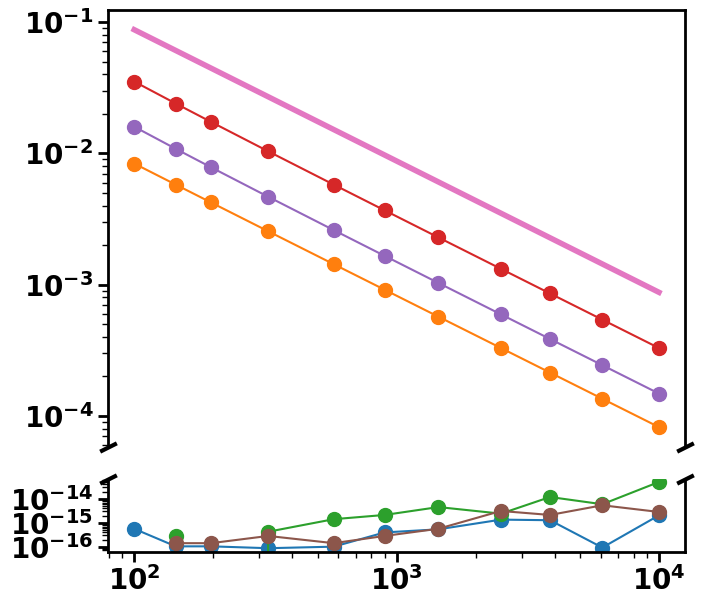

In [326]:
fig, (ax0, ax1) = plot_loglog_rel_err(Num_Vs, rel_errs)
# plt.savefig("tiling/square_periodic/square_periodic_tiling_eigenvalue_relerr.png", dpi=200, bbox_inches='tight')

### Calculate eigenfunction relative errors

In [404]:
run_eigenvector_calculations = True

In [405]:
if run_eigenvector_calculations:
    eigenfunction_errs = {}
    for en, tile_num in enumerate(tiles_per_dim):
        print(f"{en} / {len(tiles_per_dim) - 1}")
        g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                          num_horizontal_displacements=tile_num,
                                          num_vertical_displacements=tile_num,
                                          autoplot=False)
        p = Projector(g, eigenvalue_data[g.num_Vs])
        eigenfunction_errs[g.num_Vs] = {}
        for m, n in mn:
            eigenfunction_errs[g.num_Vs][m, n] = []
            A = p.project(m, n)
            B = p.construct_pde_functions(m, n, function_domain="graph")
            for i, j in zip(A, B):
                eigenfunction_errs[g.num_Vs][m, n].append((i - j).norm())

run_eigenvector_calculations = False

0 / 10
1 / 10


/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_78346/2465226739.py:154: UserWarning: For m=2,n=2, the graph eigenspace is larger than the PDE eigenspace. This might be (a) a problem, (b) be saying something interesting, or (c) nothing special.
  warnings.warn(message)


2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [406]:
eigenfunction_errs_array = []
for m, n in mn:
    eigenfunction_errs_array.append([])
    for num_Vs in eigenfunction_errs:
        eigenfunction_errs_array[-1].append(np.mean(eigenfunction_errs[num_Vs][m, n]))
eigenfunction_errs_array = np.array(eigenfunction_errs_array).T

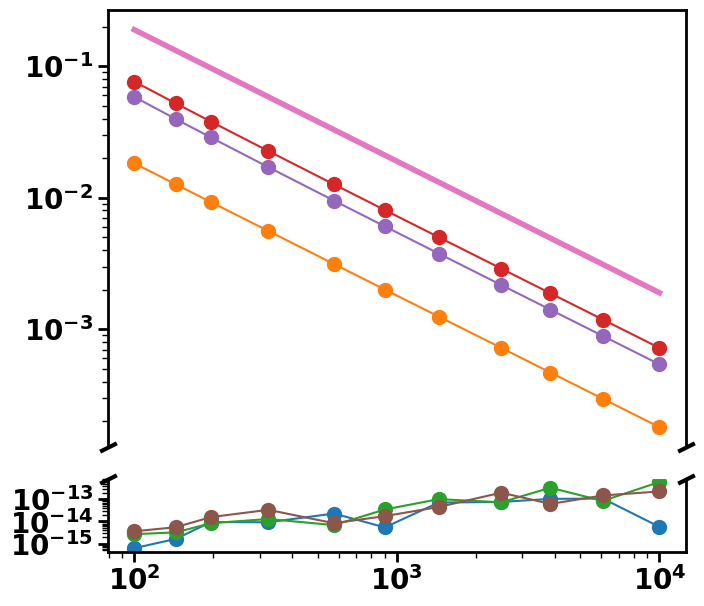

In [407]:
fig, ax = plot_loglog_rel_err(Num_Vs, eigenfunction_errs_array)
# plt.savefig("tiling/square_periodic/square_periodic_tiling_eigenfunction_relerr.png", dpi=200, bbox_inches='tight')

### Plot modes

In [422]:
class Projector:

    def __init__(self, g, graph_eigenvalues):

        self.g = g
        self.num_interior_Vs = len(self.g.interior_V_num)
        (self.graph_eigenvalues,
         self.graph_eigenvectors, 
         self.null_space_dims) = self.calculate_graph_eigenvectors(graph_eigenvalues)
        self.graph_eigenfunctions = self.construct_graph_eigenfunctions()
    
    def construct_graph_eigenfunction(self, eigenvalue, eigenvector):

        graph_eigenfunction = []

        if np.abs(eigenvalue) < 1e-13:
            for e_num, ((v_num, w_num), l_vw) in enumerate(self.g.E_lengths_by_v_num.items()):
                edge_mode = np.ones(self.g.g_coords[e_num].shape[1])
                graph_eigenfunction.append(edge_mode)
        else:
            for e_num, ((v_num, w_num), l_vw) in enumerate(self.g.E_lengths_by_v_num.items()):
                parametrised_edge = np.linspace(0, l_vw, self.g.g_coords[e_num].shape[1])

                edge_mode = ((eigenvector[v_num] * np.sin(eigenvalue * parametrised_edge[::-1])
                            + eigenvector[w_num] * np.sin(eigenvalue * parametrised_edge)) 
                            / np.sin(eigenvalue * l_vw))
                
                graph_eigenfunction.append(edge_mode)

        graph_eigenfunction = Graph_Function(graph_eigenfunction, self.g.g_coords).normalize()

        return graph_eigenfunction
    
    def construct_graph_eigenfunctions(self):

        graph_eigenfunctions = []
        for eigenvalue, eigenvector in zip(self.graph_eigenvalues, self.graph_eigenvectors.T):
            graph_eigenfunctions.append(self.construct_graph_eigenfunction(eigenvalue, eigenvector))
        
        return graph_eigenfunctions
    
    def calculate_graph_eigenvectors(self, graph_eigenvalues):

        graph_eigenvectors = []
        null_space_dims = []
        if self.g.num_Vs < 10000: tolerance = None
        else: tolerance = 1e-8

        for k in graph_eigenvalues:

            if np.abs(k) < 1e-12:
                Q, R, perm, r = sparseqr.qr(self.g.construct_L(k), tolerance=None)
            else:
                Q, R, perm, r = sparseqr.qr(self.g.construct_L(k), tolerance=tolerance)

            dim_null_space = self.num_interior_Vs - r

            null_vectors = Q.toarray()[:, -dim_null_space:]

            null_space_dims.append(dim_null_space)
            graph_eigenvectors.append(null_vectors)

        graph_eigenvalues = np.repeat(graph_eigenvalues, null_space_dims)
        graph_eigenvectors = np.hstack(graph_eigenvectors)

        return graph_eigenvalues, graph_eigenvectors, null_space_dims 

    def generate_basis_functions(self, m, n):

        if m == 0 and n == 0:
            return lambda x, y: np.ones(len(x)), 

        cc = lambda m, n: lambda x, y: np.cos(2 * np.pi * m * x) * np.cos(2 * np.pi * n * y)
        cs = lambda m, n: lambda x, y: np.cos(2 * np.pi * m * x) * np.sin(2 * np.pi * n * y)
        sc = lambda m, n: lambda x, y: np.sin(2 * np.pi * m * x) * np.cos(2 * np.pi * n * y)
        ss = lambda m, n: lambda x, y: np.sin(2 * np.pi * m * x) * np.sin(2 * np.pi * n * y)

        if m == 0:
            return cc(m, n), cs(m, n), cc(n, m), sc(n, m)
        elif n == 0:
            return cc(m, n), sc(m, n), cc(n, m), cs(n, m)
        elif m == n:
            return cc(m, n), cs(m, n), sc(m, n), ss(m, n),
        else:
            return (cc(m, n), cs(m, n), sc(m, n), ss(m, n), 
                    cc(n, m), cs(n, m), sc(n, m), ss(n, m))
        
    def construct_pde_functions(self, m, n, function_domain="vertices", basis_function_nums="all"):

        basis_functions = self.generate_basis_functions(m, n)
        if basis_function_nums == "all":
            basis_function_nums = range(len(basis_functions))
        basis_functions = tuple(basis_functions[i] for i in basis_function_nums)

        if function_domain == "vertices":

            x, y = self.g.V_coords[:, 0], self.g.V_coords[:, 1]

            pde_eigenvectors = [function(x, y) for function in basis_functions]
            pde_eigenvectors = [function / np.linalg.norm(function) for function in pde_eigenvectors]
            pde_eigenvectors = np.vstack((pde_eigenvectors)).T

            return pde_eigenvectors
        
        elif function_domain == "graph":

            num_basis_functions = len(basis_functions)
            pde_eigenfunctions = [[] for _ in range(num_basis_functions)]

            for edge in self.g.g_coords:

                x, y = edge
                
                for i in range(len(basis_functions)):
                    pde_eigenfunctions[i].append(basis_functions[i](x, y))

            pde_eigenfunctions = [Graph_Function(pde_eigenfunction, self.g.g_coords).normalize() 
                                  for pde_eigenfunction in pde_eigenfunctions]
            
            return pde_eigenfunctions

        elif function_domain == "continuum":
                
            edge = np.linspace(0, 1, 256, endpoint=True)   
            x, y = np.meshgrid(edge, edge)
            pde_eigenfunctions = [function(x, y) for function in basis_functions]

            return x, y, pde_eigenfunctions

    def find_graph_nullspace(self, m, n):

        pde_eigenvectors = self.construct_pde_functions(m, n, function_domain="vertices")
        num_basis_functions = pde_eigenvectors.shape[1]

        prod = pde_eigenvectors.T @ pde_eigenvectors
        invert_prod = np.linalg.inv(prod)
        if not np.allclose(prod @ invert_prod, np.identity(prod.shape[0])):
            raise ValueError("Numerical errors in projection matrix are too large." 
                             + "Probably from matrix inverse calculation")

        proj = (pde_eigenvectors @ invert_prod @ pde_eigenvectors.T)

        keep_args = proj @ self.graph_eigenvectors
        print(np.linalg.norm(keep_args, axis=0))
        keep_args = np.argsort(np.linalg.norm(keep_args, axis=0))[-num_basis_functions:]
        print(keep_args)

        # Handle when the graph eigenspace is larger than the PDE eigenspace
        uniques, counts = np.unique(np.round(p.graph_eigenvalues[keep_args], 10), return_counts=True)
        new_keep_args = []
        for unique, count in zip(uniques, counts):
            where_equal = np.where(np.abs(p.graph_eigenvalues - unique) < 1e-9)[0]
            if np.shape(where_equal)[0] != count:
                message = (f"For m={m},n={n}, the graph eigenspace is larger than the PDE eigenspace. " + 
                            "This might be (a) a problem, (b) be saying something interesting, or (c) nothing special.")
                warnings.warn(message)
            new_keep_args.append(where_equal)
        keep_args = np.concatenate((new_keep_args))

        return keep_args
    
    def project(self, m, n, return_args=False):

        keep_args = self.find_graph_nullspace(m, n)

        project_functions = []

        pde_eigenfunctions = self.construct_pde_functions(m, n, function_domain="graph")

        for pde_eigenfunction in pde_eigenfunctions:
            projection = []
            for arg in keep_args:
                ip = pde_eigenfunction.dot(self.graph_eigenfunctions[arg])
                projection.append(ip * self.graph_eigenfunctions[arg])
            project_functions.append(np.sum(projection))

        if return_args:
            return project_functions, keep_args
        return project_functions

In [402]:
m, n = 2, 2
A, args = p.project(m, n, return_args=True)
B = p.construct_pde_functions(m, n, function_domain="graph")
x, y, C = p.construct_pde_functions(m, n, function_domain="continuum")

/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_78346/2465226739.py:154: UserWarning: For m=2,n=2, the graph eigenspace is larger than the PDE eigenspace. This might be (a) a problem, (b) be saying something interesting, or (c) nothing special.
  warnings.warn(message)


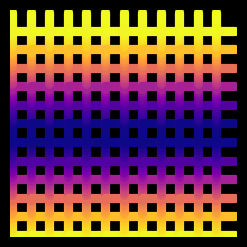

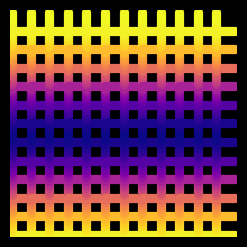

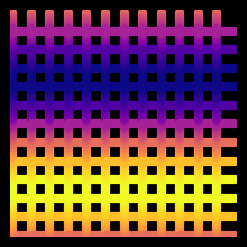

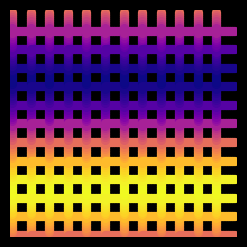

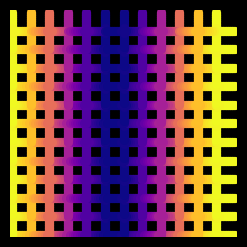

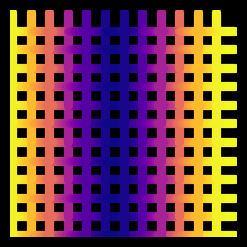

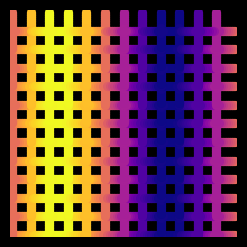

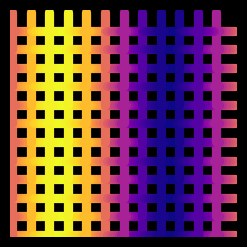

In [378]:
for en, (i, j) in enumerate(zip(A, B)):
    g.plot_graph(eigenmode=i.data, figsize=3, linewidth=generate_graph_linewidth(g.num_Vs), return_figax=True, background_color="black", capstyle="round")
    g.plot_graph(eigenmode=j.data, figsize=3, linewidth=generate_graph_linewidth(g.num_Vs), return_figax=True, background_color="black", capstyle="round")